In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def GaussianBRF(hImg, wImg, radius=10, win=5):  # 高斯带阻滤波器
    u, v = np.mgrid[-1:1:2.0/hImg, -1:1:2.0/wImg]
    D = cv.magnitude(u, v) * hImg/2  # 距离
    C0 = radius  # 滤波器半径
    kernel = 1 - np.exp(-(D-C0)**2 / (win**2))
    return kernel

In [3]:
# (1) 读取原始图像
img = cv.imread("Fig1102.png", flags=0)  # 读取灰度图像
hImg, wImg = img.shape[:2]
print("img.shape: ", img.shape[:2])

img.shape:  (540, 600)


In [4]:
# (2) 图像的傅里叶变换
imgFloat = img.astype(np.float32)  # 转换成实型
dftImg = cv.dft(imgFloat, flags=cv.DFT_COMPLEX_OUTPUT)  # (hImg,wImg,2)
dftShift = np.fft.fftshift(dftImg)  # 中心化
shiftDftAmp = cv.magnitude(dftShift[:,:,0], dftShift[:,:,1])  # 幅度谱
dftAmpLog = np.uint8(cv.normalize(np.log(1 + shiftDftAmp), None, 0, 255, cv.NORM_MINMAX))

选中亮斑可以剔除掉特定频率的干扰

In [5]:
# (3) 鼠标交互框选频谱中的亮斑
rect = cv.selectROI("DftAmp", dftAmpLog)  # 鼠标左键拖动选择矩形框
print("selectROI:", rect)  # 元组 (xmin, ymin, w, h)
x, y, w, h = rect  # 框选矩形区域 (ymin:ymin+h, xmin:xmin+w)
imgROI = np.zeros(img.shape[:2], np.uint8)  # 创建掩模图像
imgROI[y:y+h, x:x+w] = 1  # 框选矩形区域作为掩模窗口
minVal, maxVal, minLoc, maxLoc = cv.minMaxLoc(dftAmpLog, mask=imgROI)  # 查找最大值位置
cx, cy = maxLoc[0]-wImg//2, maxLoc[1]-hImg//2  # 以图像中心为原点的坐标
print("Position of maximum: cx={},cy={}".format(cx, cy))
dftLabelled = dftAmpLog.copy()
cv.rectangle(dftLabelled, (x,y), (x+w,y+h), (0,0,255), 2)  # 在频谱图上标记矩形框

selectROI: (271, 242, 20, 26)
Position of maximum: cx=-19,cy=-17


array([[ 74,  99,  92, ...,  90,  92,  99],
       [ 96,  97,  95, ..., 105,  82, 108],
       [ 60,  92, 107, ...,  92,  77, 102],
       ...,
       [107,  99, 102, ...,  98,  86,  96],
       [ 60, 102,  77, ...,  94, 107,  92],
       [ 96, 108,  82, ...,  90,  95,  97]], dtype=uint8)

In [6]:
# (4) 构造高斯带阻滤波器传递函数
cBand = np.sqrt(cx**2+cy**2)  # 计算带阻频带中心
print("Center of frequency band: {:.1f}".format(cBand))
brFilter = GaussianBRF(hImg, wImg, radius=cBand, win=8)  # 高斯带阻滤波器
filterDual = cv.merge([brFilter, brFilter])  # 拼接为2个通道：(hImg,wImg,2)

Center of frequency band: 25.5


In [7]:
# (5) 带阻滤波和傅里叶逆变换
dftBRF = dftShift * filterDual  # 带阻滤波 (hImg,wImg,2)
iShift = np.fft.ifftshift(dftBRF)  # 去中心化
idft = cv.idft(iShift)  # (hImg,wImg,2)
idftAmp = cv.magnitude(idft[:, :, 0], idft[:, :, 1])  # 重建图像
rebuild = np.uint8(cv.normalize(idftAmp, None, 0, 255, cv.NORM_MINMAX))

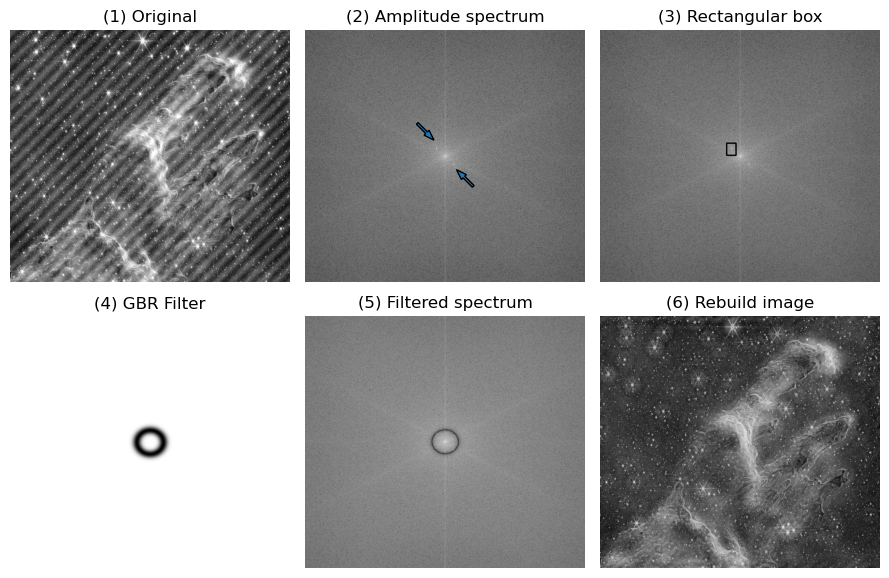

In [8]:
plt.figure(figsize=(9, 6))
plt.subplot(231), plt.title("(1) Original")
plt.axis('off'), plt.imshow(img, cmap='gray')
plt.subplot(232), plt.title("(2) Amplitude spectrum")
plt.axis('off'), plt.imshow(dftAmpLog, cmap='gray')
plt.arrow(360, 335, -20, -20, width=5, shape='full')  # 绘制箭头
plt.arrow(240, 200, 20, 20, width=5, shape='full')  # 绘制箭头
plt.subplot(233), plt.title("(3) Rectangular box")
plt.axis('off'), plt.imshow(dftLabelled, cmap='gray')
plt.subplot(234), plt.title("(4) GBR Filter")
plt.axis('off'), plt.imshow(brFilter, cmap='gray')
plt.subplot(235), plt.title("(5) Filtered spectrum")
ampFiltered = cv.magnitude(dftBRF[:,:,0], dftBRF[:,:,1])  # 幅度谱
ampLog = np.uint8(cv.normalize(np.log(1+ampFiltered), None, 0, 255, cv.NORM_MINMAX))
plt.axis('off'), plt.imshow(ampLog, cmap='gray')
plt.subplot(236), plt.title("(6) Rebuild image")
plt.imshow(rebuild, cmap='gray'), plt.axis('off')
plt.tight_layout()
plt.show()